I compared the ICRF3 X/Ka catalog with the Gaia DR2 catalog (iers_auxilary).

In [1]:
from astropy.table import Table, join, Column
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import numpy as np
import sys

import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = "svg"
# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting, residual_calc02
from my_progs.catalog.pos_diff import nor_sep_calc, pos_diff_calc
from my_progs.catalog.write_output import print_vsh1_corr, print_vsh2_corr
from my_progs.stat_func.rms_calc import rms_calc

Load the positional information from these two catalogs.

In [2]:
# Read ICRF3 K catalog
from my_progs.catalog.read_icrf import read_icrf3
icrf3xka = read_icrf3(wv="xka")

# Read Gaia DR2 IERS quasar data
from my_progs.catalog.read_gaia import read_dr2_iers

gaiadr2 = read_dr2_iers()

# A selection on the G magnitude
bgt_mask = (gaiadr2["phot_g_mean_mag"] < 18.7)
gaiadr2 = gaiadr2[bgt_mask]
gaiadr2.filled()

iers_name,source_id,ra,ra_err,dec,dec_err,pos_err,parallax,parallax_err,pmra,pmra_err,pmdec,pmdec_err,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,mag,mag,mag
bytes8,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32
2357-326,2314315845817748992,0.08499783888929553,0.1445922512977904,-32.35034287416735,0.12064481144837098,0.1459297058023392,0.2031436388244911,0.18931038055012414,-0.036379976508171166,0.2996915751383218,0.07511508120986538,0.2477794651372806,-0.092771634,0.3238576,0.26209354,-0.09424034,-0.37053558,-0.016644478,0.23910828,-0.04301203,-0.20278661,0.06913886,168,18.07359,18.252312,17.669233
2358-161,2415835442333250688,0.2722030739253465,0.20602077902948293,-15.851965536926414,0.1283223830435575,0.20605283885027792,-0.055558146475727405,0.24401150977786393,-0.2358559729612182,0.3893762964882165,-0.6856420405574464,0.29947031486611997,0.02216497,0.3860851,0.3694782,-0.18911926,-0.25913212,0.07878281,0.59325767,-0.21182266,-0.5026838,0.31012946,223,18.266418,18.379673,17.891047
0002+541,420305499589122944,1.2681808047501304,0.13120835916273907,54.47359019646749,0.13042564468464754,0.14545837311323823,-0.14358682773108555,0.19574910597769088,-0.03226026529765841,0.2462715837614524,-0.06292777713183365,0.23430898938890327,-0.23628916,0.25975955,-0.45651165,0.09144919,-0.2566045,0.0073146904,-0.41105396,-0.13174422,0.4187751,-0.12113201,379,18.539387,18.719727,17.97392
0002-170,2414919854088816640,1.324724085562965,0.12209945018003658,-16.8012994100183,0.09340584476751623,0.12802895680534068,-0.13861516190224235,0.17585208899659477,0.004812872190701029,0.2745290537552927,0.1572019487857582,0.18733964355104002,0.2956712,0.2617457,-0.11088492,-0.16225792,-0.1564921,-0.13369387,0.14287123,0.247167,-0.3034156,0.260597,197,17.744463,17.8112,17.465117
0002+051,2742071537411222144,1.3342312881365477,0.055566707261366505,5.403000767650242,0.043549317950419074,0.06716510720786427,-0.18174652464981178,0.07102249423130252,0.01592005248997215,0.1305336978096423,0.013523528754770654,0.08135638551501498,0.7972324,0.32458007,-0.3473576,-0.37228525,0.4254666,-0.28356376,-0.44606686,-0.053894896,-0.3103772,0.33574304,386,16.121809,16.325563,15.677205
0003+380,2880735415555982976,1.4882330572178368,0.2284371807502203,38.337539859379994,0.17763597364941844,0.22845829198943232,0.1593562094722022,0.3646175286281955,0.28592281784064194,0.43330939124983037,-0.26680058654512034,0.2873635197110239,-0.010995329,0.39091006,-0.22830355,0.044289686,0.058109067,-0.05278489,0.06332331,-0.313217,0.13932036,-0.18161543,284,18.399437,18.87687,17.15951
0003+158,2772557627594347904,1.4968240859821051,0.05140218702889516,16.163617167239376,0.05228218626781307,0.06443718644595192,-0.1379296031165088,0.06616279334231377,-0.16991238739920944,0.10969673915674469,-0.08304789920837208,0.09132036766296264,0.54462457,0.2148454,-0.017559756,-0.47005635,-0.1428315,-0.25400865,-0.64600486,-0.1433519,-0.087046884,0.31778336,166,15.5558605,15.670453,15.189635
0003-066,2442050857556048000,1.5578870064695536,0.09430468606721869,-6.39314865050367,0.062095265856561006,0.09842497204589487,0.21968984080969833,0.1202299976697474,-0.2807910312361741,0.21287585729116837,-0.1650042495297552,0.12258446418311031,0.36748704,0.21541953,0.022390373,-0.16457231,-0.22921939,-0.14024962,0.367701,-0.062028516,-0.44003168,0.44253242,247,17.154104,17.64587,16.27626


A crossmatch is performed to obtain a sample of common sources.

In [3]:
com_sou = join(icrf3xka, gaiadr2, keys="iers_name", table_names=["icrf3xka", "gaiadr2"])
com_sou

icrf_name,iers_name,type,ra_icrf3xka,dec_icrf3xka,ra_err_icrf3xka,dec_err_icrf3xka,ra_dec_corr_icrf3xka,mean_obs,pos_err_icrf3xka,beg_obs,end_obs,nb_sess,nb_del,source_id,ra_gaiadr2,ra_err_gaiadr2,dec_gaiadr2,dec_err_gaiadr2,pos_err_gaiadr2,parallax,parallax_err,pmra,pmra_err,pmdec,pmdec_err,ra_dec_corr_gaiadr2,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
,,,deg,deg,mas,mas,,,,,,,,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,mag,mag,mag
str16,str8,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32
J000504.3+542824,0002+541,--,1.268180768958333,54.47359004538889,0.09003805980033948,0.1306,0.1878,57364.8,0.13255795927164774,55304.5,58146.7,27,54,420305499589122944,1.2681808047501304,0.13120835916273907,54.47359019646749,0.13042564468464754,0.14545837311323823,-0.14358682773108555,0.19574910597769088,-0.03226026529765841,0.2462715837614524,-0.06292777713183365,0.23430898938890327,-0.23628916,0.25975955,-0.45651165,0.09144919,-0.2566045,0.0073146904,-0.41105396,-0.13174422,0.4187751,-0.12113201,379,18.539387,18.719727,17.97392
J000557.1+382015,0003+380,--,1.488230883375,38.33754131888889,0.05988665795370894,0.08139999999999999,-0.3088,56844.3,0.08511922253959626,53561.7,58146.9,88,126,2880735415555982976,1.4882330572178368,0.2284371807502203,38.337539859379994,0.17763597364941844,0.22845829198943232,0.1593562094722022,0.3646175286281955,0.28592281784064194,0.43330939124983037,-0.26680058654512034,0.2873635197110239,-0.010995329,0.39091006,-0.22830355,0.044289686,0.058109067,-0.05278489,0.06332331,-0.313217,0.13932036,-0.18161543,284,18.399437,18.87687,17.15951
J000613.8-062335,0003-066,--,1.5578869827083333,-6.393148639388889,0.09346512575149064,0.12929999999999997,-0.5731,56545.8,0.14394735046495033,53561.6,58146.8,92,137,2442050857556048000,1.5578870064695536,0.09430468606721869,-6.39314865050367,0.062095265856561006,0.09842497204589487,0.21968984080969833,0.1202299976697474,-0.2807910312361741,0.21287585729116837,-0.1650042495297552,0.12258446418311031,0.36748704,0.21541953,0.022390373,-0.16457231,-0.22921939,-0.14024962,0.367701,-0.062028516,-0.44003168,0.44253242,247,17.154104,17.64587,16.27626
J000903.9+062821,0006+061,--,2.266382655708333,6.47256664575,0.09225816887728226,0.119,-0.6048,56785.3,0.13620602079885977,53651.5,58146.8,77,110,2742639774468057984,2.266383380171318,0.17901906469996773,6.472567215998765,0.15313678236923897,0.22300503470053573,0.05677676624095592,0.20619087561598493,-0.33539524001957915,0.4060269052320924,-0.21859000809030496,0.29278017651270904,0.7863576,0.03272048,-0.094952874,-0.48899153,0.06531061,-0.2200228,-0.60330945,-0.32455298,-0.22589767,0.3956859,246,17.992191,18.388727,17.271818
J001031.0+105829,0007+106,D,2.629191267708333,10.974862303833333,0.05522123270593726,0.08829999999999999,-0.4731,56132.3,0.09345139236115027,53694.3,58146.9,113,179,2753828099849995776,2.6291913864114305,0.07220077482853457,10.974862370062839,0.06707566002756404,0.0875928007083494,0.018340715809109804,0.08860360711177596,0.07580367036677091,0.18396191345882698,-0.09401610870812523,0.1295897760761274,0.57687277,-0.1823899,0.18857054,-0.47303343,-0.3376961,-0.09783556,-0.7220726,-0.3267124,0.20573594,0.17586473,194,15.943655,16.163437,15.158809
J001945.7+732730,0016+731,D,4.940776735791666,73.45833820388889,0.052657569743419445,0.0503,0.0958,55770.3,0.05415467398968593,53568.0,58147.1,64,166,537742721644001920,4.940776314078512,0.16020051530807236,73.45833822230225,0.11505440453652195,0.16020080047840168,-0.09481327030777918,0.15522945480726397,0.9889552404001566,0.304919629409891

There are 2818 common sources: 250 so-called ICRF3 defining sources and 2568 other sources.

Next step is to calculate the positional offset (ICRF3XKa - GaiaDR2).

In [4]:
[dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov, ang_sep, X_a, X_d,
 X] = pos_diff_calc(com_sou["ra_icrf3xka"], com_sou["ra_err_icrf3xka"],
                    com_sou["dec_icrf3xka"], com_sou["dec_err_icrf3xka"],
                    com_sou["ra_dec_corr_icrf3xka"], com_sou["ra_gaiadr2"],
                    com_sou["ra_err_gaiadr2"], com_sou["dec_gaiadr2"],
                    com_sou["dec_err_gaiadr2"], com_sou["ra_dec_corr_gaiadr2"])

com_sou.add_columns(
    [dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov, ang_sep, X_a, X_d, X],
    names=[
        "dra", "ddec", "dra_err", "ddec_err", "dra_ddec_cov", "ang_sep",
        "nor_dra", "nor_ddec", "nor_sep"
    ])

com_sou["dra"].unit = u.mas
com_sou["ddec"].unit = u.mas
com_sou["dra_err"].unit = u.mas

com_sou

icrf_name,iers_name,type,ra_icrf3xka,dec_icrf3xka,ra_err_icrf3xka,dec_err_icrf3xka,ra_dec_corr_icrf3xka,mean_obs,pos_err_icrf3xka,beg_obs,end_obs,nb_sess,nb_del,source_id,ra_gaiadr2,ra_err_gaiadr2,dec_gaiadr2,dec_err_gaiadr2,pos_err_gaiadr2,parallax,parallax_err,pmra,pmra_err,pmdec,pmdec_err,ra_dec_corr_gaiadr2,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,dra,ddec,dra_err,ddec_err,dra_ddec_cov,ang_sep,nor_dra,nor_ddec,nor_sep
,,,deg,deg,mas,mas,,,,,,,,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,mag,mag,mag,mas,mas,mas,mas,,deg,deg,deg,deg
str16,str8,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
J000504.3+542824,0002+541,--,1.268180768958333,54.47359004538889,0.09003805980033948,0.1306,0.1878,57364.8,0.13255795927164774,55304.5,58146.7,27,54,420305499589122944,1.2681808047501304,0.13120835916273907,54.47359019646749,0.13042564468464754,0.14545837311323823,-0.14358682773108555,0.19574910597769088,-0.03226026529765841,0.2462715837614524,-0.06292777713183365,0.23430898938890327,-0.23628916,0.25975955,-0.45651165,0.09144919,-0.2566045,0.0073146904,-0.41105396,-0.13174422,0.4187751,-0.12113201,379,18.539387,18.719727,17.97392,-0.07487219328545741,-0.5438829674631052,0.15913040478421414,0.1845730445959158,-0.0018352662897061236,0.5490123201020611,-0.47050840715818243,-2.9467085437845135,3.0188271007612983
J000557.1+382015,0003+380,--,1.488230883375,38.33754131888889,0.05988665795370894,0.08139999999999999,-0.3088,56844.3,0.08511922253959626,53561.7,58146.9,88,126,2880735415555982976,1.4882330572178368,0.2284371807502203,38.337539859379994,0.17763597364941844,0.22845829198943232,0.1593562094722022,0.3646175286281955,0.28592281784064194,0.43330939124983037,-0.26680058654512034,0.2873635197110239,-0.010995329,0.39091006,-0.22830355,0.044289686,0.058109067,-0.05278489,0.06332331,-0.313217,0.13932036,-0.18161543,284,18.399437,18.87687,17.15951,-6.138350447884974,5.254232019069605,0.23615663731932954,0.19539830893428142,-0.0019515059408669005,8.079993832377962,-25.9927077111313,26.88985410225207,36.632872956256385
J000613.8-062335,0003-066,--,1.5578869827083333,-6.393148639388889,0.09346512575149064,0.12929999999999997,-0.5731,56545.8,0.14394735046495033,53561.6,58146.8,92,137,2442050857556048000,1.5578870064695536,0.09430468606721869,-6.39314865050367,0.062095265856561006,0.09842497204589487,0.21968984080969833,0.1202299976697474,-0.2807910312361741,0.21287585729116837,-0.1650042495297552,0.12258446418311031,0.36748704,0.21541953,0.022390373,-0.16457231,-0.22921939,-0.14024962,0.367701,-0.062028516,-0.44003168,0.44253242,247,17.154104,17.64587,16.27626,-0.08500843811112255,0.04001320874635894,0.13277463442231213,0.14343748478621962,-0.004773978834921436,0.09395473071789547,-0.6402460717062783,0.2789592191050683,0.651836526387856
J000903.9+062821,0006+061,--,2.266382655708333,6.47256664575,0.09225816887728226,0.119,-0.6048,56785.3,0.13620602079885977,53651.5,58146.8,77,110,2742639774468057984,2.266383380171318,0.17901906469996773,6.472567215998765,0.15313678236923897,0.22300503470053573,0.05677676624095592,0.20619087561598493,-0.33539524001957915,0.4060269052320924,-0.21859000809030496,0.29278017651270904,0.7863576,0.03272048,-0.094952874,-0.48899153,0.06531061,-0.2200228,-0.60330945,-0.32455298,-0.22589767,0.3956859,246,17.992191,18.388727,17.271818,-2.5914427808355254,-2.052895555948453,0.20139363259706194,0.19393780991442502,0.014917592953817902,3.3060483738108655,-12.867550713583638,-10.585329167398005,14.255643883728343
J

In [5]:
# Seperate the sources into the "defining sources" and "other sources".
# Defining sources
mask_def = (com_sou["type"] == "D")
com_def = com_sou[mask_def]

# Other sources
mask_oth = (com_sou["type"] != "D")
com_oth = com_sou[mask_oth]

Several plots related to the positional difference.

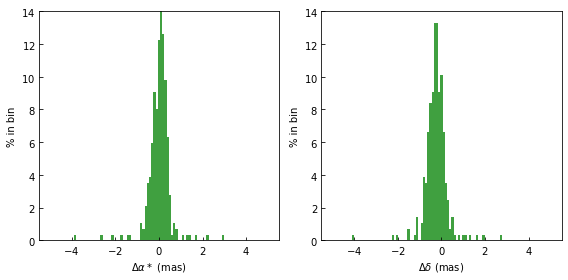

In [6]:
# Difference in RA and decl.
bins_array = np.linspace(-5, 5, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dRA, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(dDC, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 16, 2))
ax1.set_yticks(np.arange(0, 16, 2))

ax0.set_ylim([0, 14])
ax1.set_ylim([0, 14])

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

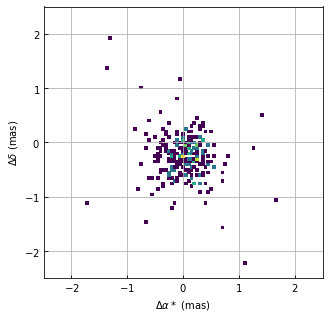

In [7]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(5, 5))

bins = np.linspace(-2.5, 2.5, 100)

# We can increase the number of bins on each axis
ax.hist2d(dRA, dDC, bins, norm=colors.LogNorm())

ax.set_xlabel("$\Delta\\alpha*$ (mas)")
ax.set_ylabel("$\Delta\\delta$ (mas)")

ax.grid(True)

plt.show()

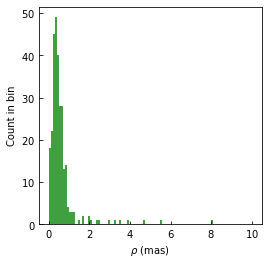

In [8]:
# Distribution of angular separation
bins_array = np.linspace(0, 10, 100)

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(ang_sep, bins_array, facecolor="g", alpha=0.75)

ax.set_xlabel("$\\rho$ (mas)")
ax.set_ylabel("Count in bin")

plt.show()

In [9]:
std_ra = np.std(dRA)
std_dec = np.std(dDC)
_, wrms_ra, _ = rms_calc(dRA, dRA_err)
_, wrms_dec, _ = rms_calc(dDC, dDC_err)

std_ra, std_dec, wrms_ra, wrms_dec

(0.9288055638379056,
 0.8139593529066947,
 0.5685240295139882,
 0.4831553178603573)

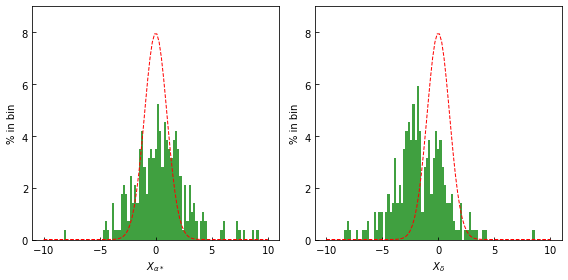

In [10]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(X_a, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(X_d, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylim([0, 9])
ax1.set_ylim([0, 9])

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 10, 2))
ax1.set_yticks(np.arange(0, 10, 2))

fig.tight_layout()
plt.show()

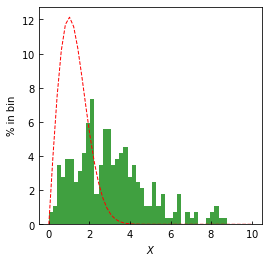

In [11]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X) * 100. / X.size

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(X, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rayleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.set_xlabel("$X$")
ax.set_ylabel("% in bin")

plt.show()

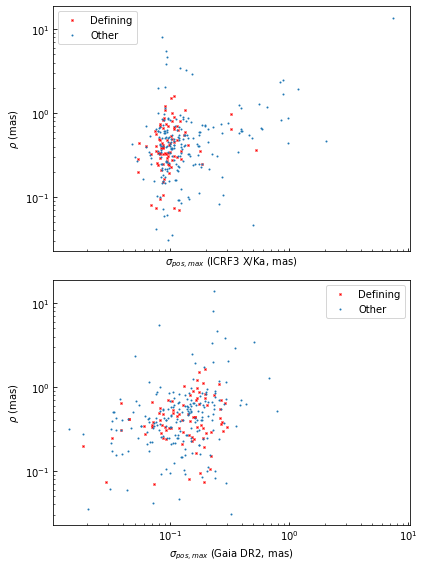

In [12]:
# Angular position difference vs. positional uncertainty
fig, (ax0, ax1) = plt.subplots(figsize=(6, 8), nrows=2, sharex=True)

ax0.plot(com_def["pos_err_icrf3xka"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")
ax1.plot(com_def["pos_err_gaiadr2"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")

ax0.plot(com_oth["pos_err_icrf3xka"],
         com_oth["ang_sep"], ".", ms=2, label="Other")
ax1.plot(com_oth["pos_err_gaiadr2"],
         com_oth["ang_sep"], ".", ms=2, label="Other")

ax0.set_xscale("log")
ax0.set_yscale("log")
ax1.set_xscale("log")
ax1.set_yscale("log")

ax0.set_xlabel("$\sigma_{pos,max}$ (ICRF3 X/Ka, mas)")
ax0.set_ylabel("$\\rho$ (mas)")
ax1.set_xlabel("$\sigma_{pos,max}$ (Gaia DR2, mas)")
ax1.set_ylabel("$\\rho$ (mas)")


ax0.legend()
ax1.legend()

fig.tight_layout()
plt.show()

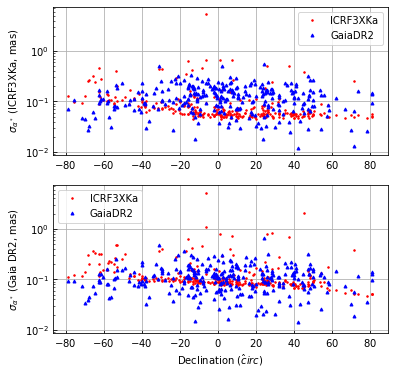

In [28]:
# Positional uncertainty for common sources as a function of declination
fig, (ax0, ax1) = plt.subplots(figsize=(6, 6), nrows=2, sharey=True)

ax0.plot(com_sou["dec_icrf3xka"], com_sou["ra_err_icrf3xka"], "r.", ms=3, label="ICRF3XKa")
ax0.plot(com_sou["dec_gaiadr2"], com_sou["ra_err_gaiadr2"], "b^", ms=3, label="GaiaDR2")

ax0.set_yscale("log")
ax0.set_ylabel("$\sigma_{\\alpha^*}$ (ICRF3XKa, mas)")
ax0.grid()

ax1.plot(com_sou["dec_icrf3xka"], com_sou["dec_err_icrf3xka"], "r.", ms=3, label="ICRF3XKa")
ax1.plot(com_sou["dec_gaiadr2"], com_sou["dec_err_gaiadr2"], "b^", ms=3, label="GaiaDR2")
ax1.set_yscale("log")
ax1.set_ylabel("$\sigma_{\\alpha^*}$ (Gaia DR2, mas)")
ax1.set_xlabel("Declination ($\^circ$)")

ax1.grid()
ax0.legend()
ax1.legend()


/usr/local/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


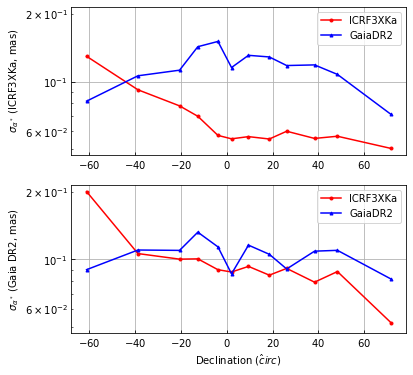

In [27]:
com_sou.sort("dec_icrf3xka")
binsize = 25

comsou_bin = np.trunc(np.arange(len(com_sou)) / binsize)
comsou_grouped = com_sou.group_by(comsou_bin)
com_binned = comsou_grouped.groups.aggregate(np.median)

fig, (ax0, ax1) = plt.subplots(figsize=(6, 6), nrows=2, sharey=True)

ax0.plot(com_binned["dec_icrf3xka"], com_binned["ra_err_icrf3xka"], "ro-", ms=3, label="ICRF3XKa")
ax0.plot(com_binned["dec_gaiadr2"], com_binned["ra_err_gaiadr2"], "b^-", ms=3, label="GaiaDR2")

ax0.set_yscale("log")
ax0.set_ylabel("$\sigma_{\\alpha^*}$ (ICRF3XKa, mas)")
ax0.grid()
ax0.legend()

ax1.plot(com_binned["dec_icrf3xka"], com_binned["dec_err_icrf3xka"], "ro-", ms=3, label="ICRF3XKa")
ax1.plot(com_binned["dec_gaiadr2"], com_binned["dec_err_gaiadr2"], "b^-", ms=3, label="GaiaDR2")
ax1.set_yscale("log")
ax1.set_ylabel("$\sigma_{\\alpha^*}$ (Gaia DR2, mas)")
ax1.set_xlabel("Declination ($\^circ$)")

ax1.grid()
ax1.legend()

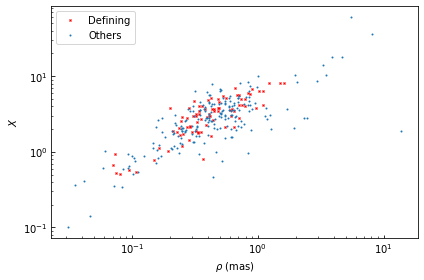

In [15]:
# Angular separation vs. normalized separation
fig, ax = plt.subplots()

ax.plot(com_def["ang_sep"],
         com_def["nor_sep"], "rx", ms=2, label="Defining")
ax.plot(com_oth["ang_sep"],
         com_oth["nor_sep"], ".", ms=2, label="Others")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("$\\rho$ (mas)")
ax.set_ylabel("$X$")

ax.legend()

fig.tight_layout()
plt.show()

Then I investigate the systematics through the 16-parameters transformation.

In [16]:
# Try with all the sources
# Transform columns into np.array
dra = np.array(com_sou["dra"])
ddec = np.array(com_sou["ddec"])
dra_err = np.array(com_sou["dra_err"])
ddec_err = np.array(com_sou["ddec_err"])
ra_rad = np.array(com_sou["ra_icrf3xka"].to(u.radian))
dec_rad = np.array(com_sou["dec_icrf3xka"].to(u.radian))
dra_ddec_cov = np.array(com_sou["dra_ddec_cov"])

# Transformation parameters
# l_max = 1
w1_all, sig1_all, corrcoef1_all = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_all, sig2_all, corrcoef2_all = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1_all * 1.e3
sig1 = sig1_all * 1.e3
w2 = w2_all * 1.e3
sig2 = sig2_all * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_all, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_all, deci_digit=1, included_one=False)

Estimates (   286 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1   -11 +/-  41   -98 +/-  39   +24 +/-  33     -31 +/-  38    +6 +/-  35  -263 +/-  38
l_max=2    -8 +/-  42  -116 +/-  41   -22 +/-  35     -52 +/-  41   +44 +/-  40  -313 +/-  39
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22        3    22
            EI22      -22    22
            ER21      -45    47
            EI21       76    50
             E20      162    48
            MR22       -8    24
            MI22       14    24
            MR21       92    47
     

In [17]:
# Remove the outlier (consider the normalized separation)
N = len(com_sou)
X0 = np.sqrt(np.log(N) * 2)
# X0 = 3.41

print("There are %d sources.\n"
      "When X >= %.2f, the number of the outlier is smaller than 1." % (N, X0))

mask = ((com_sou["nor_sep"] <= X0)
        & (com_sou["ang_sep"] < 10))

# Table of a clean sample
com_clean = com_sou[mask]
N1 = len(com_clean)
print("After elimination, there are %d sources in the clean sample." % N1)
print("The outlier rate is %%%.0f" % ((N-N1)/N*100))

There are 286 sources.
When X >= 3.36, the number of the outlier is smaller than 1.
After elimination, there are 168 sources in the clean sample.
The outlier rate is %41


In [18]:
# Transform columns into np.array
dra = np.array(com_clean["dra"])
ddec = np.array(com_clean["ddec"])
dra_err = np.array(com_clean["dra_err"])
ddec_err = np.array(com_clean["ddec_err"])
ra_rad = np.array(com_clean["ra_icrf3xka"].to(u.radian))
dec_rad = np.array(com_clean["dec_icrf3xka"].to(u.radian))
dra_ddec_cov = np.array(com_clean["dra_ddec_cov"])

In [19]:
# Transformation parameters
# l_max = 1
w1_cln, sig1_cln, corrcoef1_cln = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_cln, sig2_cln, corrcoef2_cln = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None", flog=sys.stdout)

# mas -> uas
w1 = w1_cln * 1.e3
sig1 = sig1_cln * 1.e3
w2 = w2_cln * 1.e3
sig2 = sig2_cln * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_cln, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_cln, deci_digit=1, included_one=False)

# apriori statistics (weighted)
#         mean for RA:      0.025 
#         wrms for RA:      0.314 
#          std for RA:      0.312 
#        mean for Dec:     -0.138 
#        wrms for Dec:      0.405 
#         std for Dec:      0.379 

# apriori reduced Chi-square for:      2.165
# posteriori statistics  of vsh01 fit (weighted)
#         mean for RA:      0.003 
#          rms for RA:      0.301 
#          std for RA:      0.301 
#        mean for Dec:      0.020 
#         rms for Dec:      0.373 
#         std for Dec:      0.371 

# posteriori reduced Chi-square for:      1.311
# goodness-of-fit is      0.000
Estimates (   168 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
------------------------------------------------------------------------

Then I check the residuals of positional offsets.

In [20]:
# Remove the systematics
RA = np.array(com_sou["ra_icrf3xka"].to(u.radian))
DE = np.array(com_sou["dec_icrf3xka"].to(u.radian))

# dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_cln)
dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_all)

# Now re-calculate the normalized difference
ang_sep_ns, Xa_ns, Xd_ns, X_ns = nor_sep_calc(
    dra_ns, dRA_err, ddec_ns, dDC_err, dRA_dDC_cov/dRA_err/dDC_err)

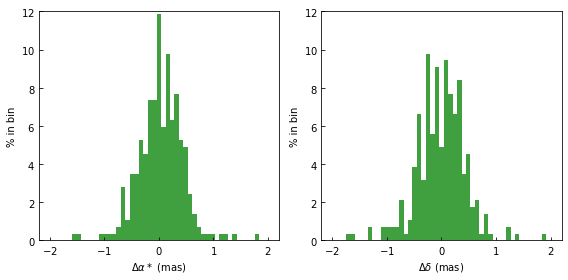

In [21]:
# Difference in RA and decl.
bins_array = np.linspace(-2, 2, 50)
weights = np.ones_like(dra_ns) * 100. / dra_ns.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dra_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(ddec_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 14, 2))
ax1.set_yticks(np.arange(0, 14, 2))

ax0.set_ylim([0, 12])
ax1.set_ylim([0, 12])
 
ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

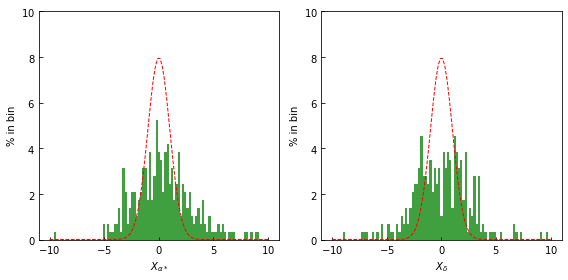

In [22]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(Xa_ns) * 100. / Xa_ns.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(Xa_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(Xd_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 11, 2))
ax1.set_yticks(np.arange(0, 11, 2))

fig.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

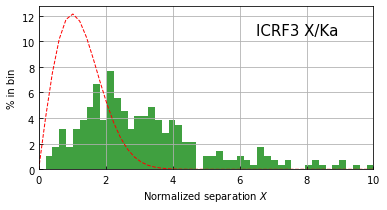

In [23]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X_ns) * 100. / X_ns.size

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(X_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.text(6.5, 10.5, "ICRF3 X/Ka", fontsize=15)

ax.set_xlim([0, 10])
ax.set_xlabel("Normalized separation $X$")
ax.set_ylabel("% in bin")
ax.grid()

plt.savefig("../plots/x_icrf3xka_gaiadr2_bgt.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


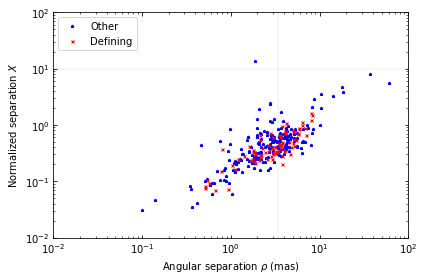

In [24]:
# Angular separation vs. normalized separation
fig, ax = plt.subplots()

ax.plot(com_oth["nor_sep"], com_oth["ang_sep"], "b*", ms=3, label="Other")
ax.plot(com_def["nor_sep"], com_def["ang_sep"], "rx", ms=3, label="Defining")
ax.hlines(10, 0.01, 100, colors="k", linestyles="dashed", lw=0.1)
ax.vlines(X0, 0.01, 100, colors="k", linestyles="dashed", lw=0.1)

ax.set_xscale("log")
ax.set_yscale("log")


ax.set_ylabel("Normalized separation $X$")
ax.set_xlabel("Angular separation $\\rho$ (mas)")

ax.set_xlim([0.01, 100])
ax.set_ylim([0.01, 100])

ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.legend(loc="upper left")
fig.tight_layout()

plt.savefig("../plots/separation_icrf3xka_gaiadr2_bgt.eps")

In [25]:
# The last step is to save the 16 transformation parameters for further use.
# Transformation parameters using the whole sample
vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2_all*1e3, sig2_all*1e3], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf3xka_gaiadr2_bgt_vsh02_all.log",
             format="ascii", overwrite=True)

# Transformation parameters using the clean sample
vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf3xka_gaiadr2_bgt_vsh02.log",
             format="ascii", overwrite=True)